In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from scipy.optimize import curve_fit
import sympy as sp
from scipy.optimize import newton

# Helper functions

In [2]:
def droplet_radius(density):
    center = tuple([ l//2 for l in density.shape ])
    rho_d = density[center]
    rho_m = density[0,0,0]
    mass = np.sum(density - rho_m)
    R = (3./4./np.pi*mass/(rho_d-rho_m))**(1./3.)
    return R

In [3]:
def pressure_jump(pressure):
    center = tuple([ l//2 for l in pressure.shape ])
    dP = pressure[center] - pressure[0,0,0]
    return dP

# Surface tension plots

Using Young-Laplace equation

$$\Delta P = \frac{\sigma}{2R_{D}}$$

In [8]:
chi, kappa, phi0, T = sp.symbols("chi, kappa, phi0, T")

def fb(phi, l, T, rho = 1):
    return -(l/2)*(phi/rho) + (T/2)*np.log((1 + phi/rho)/(1 - phi/rho))

b = sp.sqrt(kappa*(chi/T - 2))
sigma = (np.sqrt(2)*kappa**2*phi0**2)/(2*T*b)*(chi - 2*T)

# sigma = np.sqrt(6)*kappa*phi0**2*(chi - sp.Rational(2)*T)/(sp.Rational(2)*T*sp.sqrt(chi/T - sp.Rational(2)))

L = 32
k = 0.03
temp = 0.5
c = 1.1
idx = -1
rho = 1.0

sigma_theory = sigma.subs({chi:c, T:temp, kappa:k, phi0:newton(fb, x0 = (0.55), args = (c, temp))})
sigma_theory

0.000415637984256172

In [5]:
R_s = [0.25, 0.3, 0.35]

x = np.zeros(len(R_s))
y = np.zeros(len(R_s))

for i, R in enumerate(R_s):
    ts = yt.load(f"R_{R}/"+"hydro_plt*")
    ds = ts[idx]
    ad = ds.all_data()

    density = ad[("boxlib", "density")].reshape(L, L, L)
    phi = ad[("boxlib", "phi")].reshape(L, L, L)
    # pressure = np.zeros([L, L, L])
    # pressure = ad[("boxlib", "mf4")].reshape(L, L, L)
    # pressure -= ad[("boxlib", "density")].reshape(L, L, L)
    # for j in range(4, 7):
        # pressure += ad[("boxlib", f"mf{j}")].reshape(L, L, L)
    pressure = density*temp/3
    # pressure /= 3
    
    dP = pressure_jump(pressure)
    Rd = droplet_radius(phi)
    
    x[i] = 1/(2*Rd)
    y[i] = dP

yt : [INFO     ] 2024-09-20 16:29:05,234 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-20 16:29:05,235 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-20 16:29:05,236 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-20 16:29:05,236 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-20 16:29:05,373 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-20 16:29:05,373 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-20 16:29:05,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-09-20 16:29:05,375 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-09-20 16:29:05,511 Parameters: current_time              = 20000.0
yt : [INFO     ] 2024-09-20 16:29:05,512 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-09-20 16:29:05,512 Parameters: domain_left_edge          = [0. 0. 0

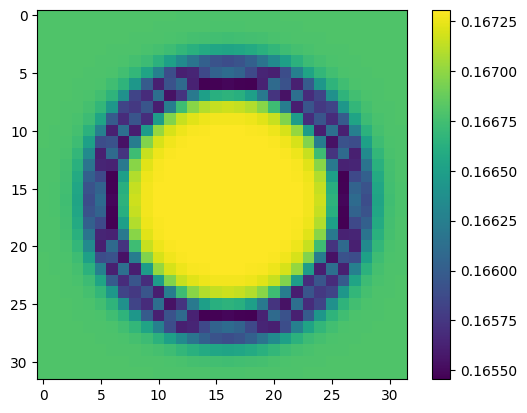

In [6]:
plt.imshow(pressure[:, L//2, :])
plt.colorbar()

Text(0.2, 0.8, '$\\sigma$ = 1.121e-02')

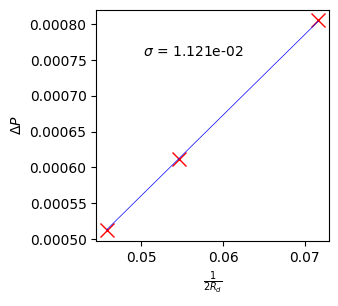

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (3, 3))

ax.plot(x, y, 'rx', label = "Raw data", ms = 10)
ax.set_ylabel(r"$\Delta P$")
ax.set_xlabel(r"$\frac{1}{2R_d}$")

func = lambda x, a: a*x
popt, pcov = curve_fit(func, x, y)
xfit = np.linspace(x.min(), x.max(), 101)
yfit = func(xfit, *popt)
ax.plot(xfit, yfit, "-b", lw = 0.5)

ax.text(0.2, 0.8, f"$\sigma$ = {popt[0]:.3e}", transform=ax.transAxes)

In [9]:
popt[0]/sigma_theory

26.9813689730370

# Flat interface

In [ ]:
ts = yt.load("hydro_plt*")
ds = ts[-1]
ad = ds.all_data()
phi = ad[("boxlib", "phi")].reshape(L, L, L)

plt.imshow(phi[:, :, L//2])

In [82]:
test = np.gradient(np.array(phi), axis = 0)

In [ ]:
profile = test[:, L//2, L//2]
plt.plot(profile[L//4:3*L//4])

In [ ]:
segment = profile[L//4:3*L//4]**2
np.sum(segment)

In [ ]:
"Kappa = 0.03, chi = 1.1, T = 0.5, sigma = 0.28634724137791745"
"Kappa = 0.01, chi = 1.1, T = 0.5, sigma = 0.4171736539177257"